In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import constants as const
import db_operations as dbop
import data_prepare as dp
import ml_model

import xgboost.sklearn as xgb
import lightgbm.sklearn as lgbm
import sklearn.preprocessing as preproc
import sklearn.metrics as metrics

import datetime
import time

2018-01-01 2011-02-27 2009-02-07
start: 2009-02-07


min_date 2009-02-09


count stck 58
(119802, 143)
(119802, 143)


(2389, 395) 2389


(119802, 538)


df_all: (99573, 538)


y<-0.5: 0
-0.50<=y<-0.40: 1
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 2
-0.20<=y<-0.10: 49
-0.10<=y<0.00: 6589
0.00<=y<0.10: 54713
0.10<=y<0.20: 23622
0.20<=y<0.30: 7906
0.30<=y<0.40: 2857
0.40<=y<0.50: 1189
y>0.5 1483
mean: 0.10512079369721224 median: 0.07169344870210126 std: 0.2097293200331299
过滤涨停项或停牌（最高价=最低价）： 5408


y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 0
-0.20<=y<-0.10: 45
-0.10<=y<0.00: 6521
0.00<=y<0.10: 56321
0.10<=y<0.20: 23167
0.20<=y<0.30: 7618
0.30<=y<0.40: 2634
0.40<=y<0.50: 1056
y>0.5 1049
mean: 0.09602441787210458 median: 0.06809229037704001 std: 0.10939949226881739
y<-0.5: 259
-0.50<=y<-0.40: 449
-0.40<=y<-0.30: 1373
-0.30<=y<-0.20: 4773


-0.20<=y<-0.10: 22424
-0.10<=y<0.00: 63870
0.00<=y<0.10: 5265
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.07977053948760486 median: -0.05882352941176483 std: 0.07881259561400997
过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 187
-0.50<=y<-0.40: 373
-0.40<=y<-0.30: 1281
-0.30<=y<-0.20: 4608
-0.20<=y<-0.10: 21963
-0.10<=y<0.00: 63145
0.00<=y<0.10: 6856
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0


mean: -0.07717436043985301 median: -0.0567685589519652 std: 0.07601330776604871
y<-0.5: 1
-0.50<=y<-0.40: 1
-0.40<=y<-0.30: 1
-0.30<=y<-0.20: 5
-0.20<=y<-0.10: 105
-0.10<=y<0.00: 13746
0.00<=y<0.10: 73922
0.10<=y<0.20: 9446
0.20<=y<0.30: 1524
0.30<=y<0.40: 361
0.40<=y<0.50: 141
y>0.5 30
mean: 0.043285505179587264 median: 0.02985074626865658 std: 0.12901851455671642


过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 0
-0.50<=y<-0.40: 0
-0.40<=y<-0.30: 0
-0.30<=y<-0.20: 4
-0.20<=y<-0.10: 99
-0.10<=y<0.00: 13641
0.00<=y<0.10: 74624
0.10<=y<0.20: 9196
0.20<=y<0.30: 1353
0.30<=y<0.40: 286
0.40<=y<0.50: 66
y>0.5 14
mean: 0.040788955311571055 median: 0.02887139107611536 std: 0.05356288397582179
y<-0.5: 8
-0.50<=y<-0.40: 11
-0.40<=y<-0.30: 138
-0.30<=y<-0.20: 792
-0.20<=y<-0.10: 7292
-0.10<=y<0.00: 83542


0.00<=y<0.10: 7500
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0
mean: -0.04039733274113943 median: -0.028132992327365547 std: 0.042994759228890206
过滤涨停项或停牌（最高价=最低价）： 5408
y<-0.5: 0
-0.50<=y<-0.40: 7
-0.40<=y<-0.30: 121
-0.30<=y<-0.20: 767
-0.20<=y<-0.10: 7121
-0.10<=y<0.00: 82978
0.00<=y<0.10: 8289
0.10<=y<0.20: 0
0.20<=y<0.30: 0
0.30<=y<0.40: 0
0.40<=y<0.50: 0
y>0.5 0


mean: -0.03970314220265873 median: -0.027626459143968995 std: 0.04197491124530424
(99573, 521) (99573, 4) Index(['y_l_rise', 'y_l_decline', 'y_s_rise', 'y_s_decline'], dtype='object')


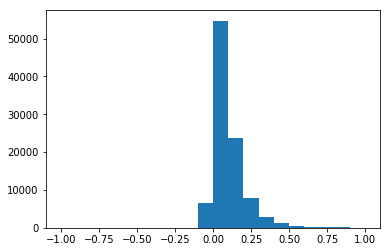

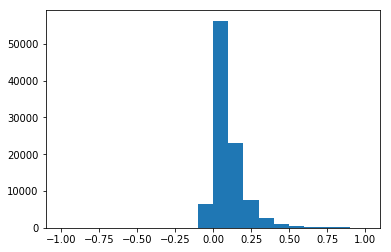

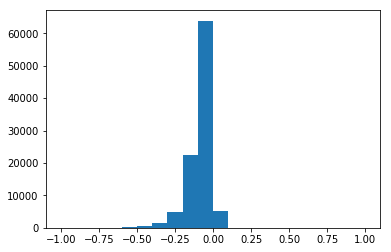

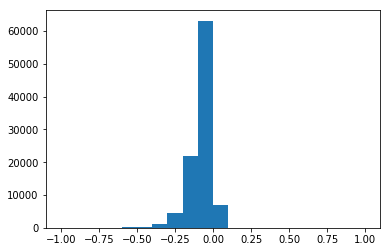

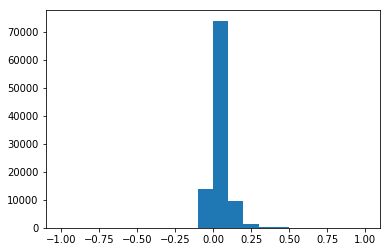

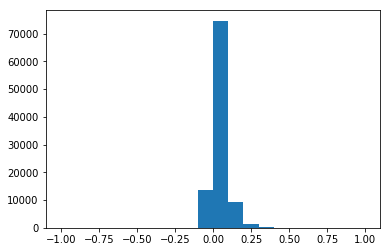

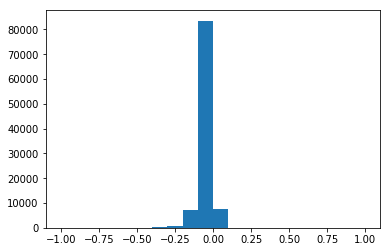

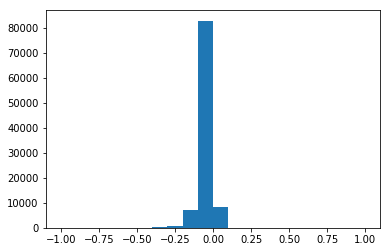

In [23]:
targets = [{"period": 20, "fun": "max", "col": "high"},
                   {"period": 20, "fun": "min", "col": "low"},
                   {"period": 5, "fun": "max", "col": "high"},
                   {"period": 5, "fun": "min", "col": "low"}]

time_delta = datetime.timedelta(days=1)
test_start = "2018-01-01"
train_length = 2500
max_feature_length = 750

train_bound = datetime.datetime.strptime(test_start, const.DATE_FORMAT) - train_length * time_delta
train_bound = datetime.datetime.strftime(train_bound, const.DATE_FORMAT)

lower_bound = datetime.datetime.strptime(train_bound, const.DATE_FORMAT) - max_feature_length * time_delta
lower_bound = datetime.datetime.strftime(lower_bound, const.DATE_FORMAT)
print(test_start,train_bound,lower_bound)

df_all, cols_future = ml_model.gen_data(targets=targets,
                                        lower_bound=lower_bound,
                                        start=train_bound,
                                        stock_pool=None)

print("df_all:", df_all.shape)
trading_date_idxes = df_all.index.unique().sort_values(ascending=True)

X = ml_model.gen_X(df_all, cols_future)

paras = [("y_l_rise", {"pred_period": 20, "is_high": True, "is_clf": False,"threshold":0.2}, df_all),
         ("y_l_decline", {"pred_period": 20, "is_high": False, "is_clf": False, "threshold":0.2}, df_all),
         ("y_s_rise", {"pred_period": 5, "is_high": True, "is_clf": False,"threshold":0.1}, df_all),
         ("y_s_decline", {"pred_period": 5, "is_high": False, "is_clf": False,"threshold":0.1}, df_all), ]
Y = pd.concat([ml_model.gen_y(v2, **v1) for k, v1, v2 in paras], axis=1)
Y.columns = [k for k, _, _ in paras]
Y.index = X.index
print(X.shape, Y.shape, Y.columns)

In [3]:
# Y is contiguous.
for col in Y.columns:
    print(col, Y[col].mean(),Y[col].median(),Y[col].std())

y_l_rise 0.09602441787210458 0.06809229037704001 0.10939949226881739
y_l_decline -0.07717436043985301 -0.0567685589519652 0.07601330776604871
y_s_rise 0.040788955311571055 0.02887139107611536 0.05356288397582179
y_s_decline -0.03970314220265873 -0.027626459143968995 0.04197491124530424


In [70]:
train_date_idx = trading_date_idxes[trading_date_idxes<"2017-01-01"][:-21]
print(train_date_idx[0],train_date_idx[-1])
test_date_idx = trading_date_idxes[(trading_date_idxes>="2017-01-01")][:300]
print(test_date_idx[0],test_date_idx[-1])

ycol = "y_l_rise"
X_train = X.loc[train_date_idx]
Y_train = {ycol:Y.loc[train_date_idx, ycol]}
print(X_train.shape, Y_train[ycol].shape)
X_test = X.loc[test_date_idx]
Y_test = {ycol:Y.loc[test_date_idx,ycol]}
print(X_test.shape, Y_test[ycol].shape)


2011-02-28 2016-12-01
2017-01-03 2018-03-27


(72349, 521) (72349,)


(16568, 521) (16568,)


In [73]:
# models = {"model_l_high":
#               xgb.XGBClassifier(n_estimators=150, 
#                                   scale_pos_weight=1,
#                                 max_depth=5,
#                                  random_state=0, 
#                                   )
#           }

models = {"model_l_high":
              lgbm.LGBMClassifier(n_estimators=75, 
                                  scale_pos_weight=1,
                                 num_leaves=63, 
                                max_depth=12,
                                 random_state=0, 
                                min_child_samples=20,
                                  )
          }

y_train = ml_model.label(Y_train[ycol],threshold=0.15,is_high=True)
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

t1 = time.time()
models["model_l_high"].fit(X_train, y_train)
t2 = time.time()
print(t2-t1)
Y_test_pred ={ycol: models["model_l_high"].predict_proba(X_test)[:,1]}


73.27398586273193


2716 (0.06072287258299916, 0.041038247449980636, 0.07049463225862719, 0.49437299035369775, -0.09234608985024961)
5179 (0.09217929157042556, 0.07278481012658222, 0.08347742338038724, 0.5256410256410255, -0.04927678352537368)
4338 (0.09436321496874844, 0.0730474739823791, 0.08881314062263362, 0.741324921135647, -0.09142053445850917)
2444 (0.09506852124031527, 0.06848222587797714, 0.09971020936837445, 0.7660103626587744, -0.0708556149732621)
1159 (0.10401113906130915, 0.07420789327404109, 0.10588567562358898, 0.687140115163148, -0.10578478964401283)
496 (0.11734058002544064, 0.08737323802886132, 0.10639750186792502, 0.597989949748744, -0.04478948939982086)
175 (0.11617028672444371, 0.08066581306017917, 0.10977046454884969, 0.4978850460313513, -0.04814814814814805)
49 (0.08495080354662063, 0.07377049180327888, 0.08738981182853237, 0.3227397260273972, -0.10079184002147368)
12 (0.09293743492183493, 0.02362909892532361, 0.13723362003000297, 0.3700854700854703, -0.03076923076923066)
0 (nan, na

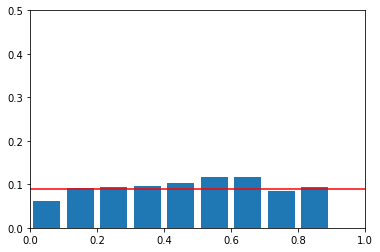

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=12, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=75,
        n_jobs=-1, num_leaves=63, objective=None, random_state=0,
        reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [74]:
x0 = np.arange(11)*0.1
y0 = np.ones(x0.shape)* Y_test[ycol].mean()

y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0 < Y_test_pred[ycol]) & (Y_test_pred[ycol] <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*0.1+0.05,[mean for mean,_, _,_,_ in y1],width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()
print(models["model_l_high"])

In [66]:
cond = Y_test_pred[ycol]>0.8
print(Y_test[ycol][cond].mean())
print(sum(cond),Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min())

df_combined = df_all.loc[test_date_idx][["code","open0","open","f1mv_open"]]
df_combined["rise"] = Y_test[ycol].copy()
df_combined["pred"] = Y_test_pred[ycol].copy()
for code, df in df_combined[cond].groupby("code"):
    print("\n",df)

0.1602977368010818
90 0.1602977368010818 0.17092363286048395 0.09845123185077884 0.44268774703557323 -0.02530802530802534



                  code  open0       open  f1mv_open      rise     pred
2018-09-28  000063.SZ  18.53  292.53311   263.6429  0.125749  0.80578

                  code  open0      open  f1mv_open      rise      pred
2018-10-18  002217.SZ   4.31  24.36012   24.36012  0.234339  0.814162

                  code  open0       open  f1mv_open      rise      pred
2018-09-17  002236.SZ  13.79  579.89708  574.00980  0.136264  0.801484
2018-09-19  002236.SZ  13.69  575.69188  582.84072  0.119048  0.809040
2018-10-11  002236.SZ  12.79  537.84508  534.06040  0.079528  0.880397
2018-10-12  002236.SZ  12.70  534.06040  555.08640  0.038636  0.862234
2018-10-15  002236.SZ  13.20  555.08640  544.15288  0.059505  0.803326
2018-10-16  002236.SZ  12.94  544.15288  538.26560  0.093750  0.830992
2018-10-17  002236.SZ  12.80  538.26560  527.75260  0.115538  0.818318
2018-10-18  002236.SZ  12.55  527.75260  503.78296  0.168614  0.826262
2018-10-19  002236.SZ  11.98  503.78296  518.92168  0.206645  0.836196
2018

In [172]:
models["model_l_high_reg"] = lgbm.LGBMRegressor(
    n_estimators=50, num_leaves=64,
    max_depth=12,
    random_state=0,
    min_child_samples=20,
    min_split_gain=5,
)
y_train = Y_train[ycol]
y_test = Y_test[ycol]

t1 = time.time()
models["model_l_high_reg"].fit(X_train, y_train)
t2 = time.time()
print(t2-t1)
Y_test_pred_reg ={ycol: models["model_l_high_reg"].predict(X_test)}
print(models["model_l_high_reg"].score(X_test,y_test))


19.164011478424072


-6.402568840580483


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

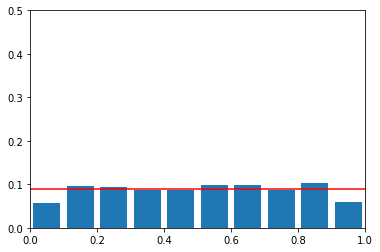

In [179]:
stacker = lgbm.LGBMClassifier(
    n_estimators=30, num_leaves=32,
    scale_pos_weight=1,
    max_depth=12,
    random_state=0,
    min_child_samples=20,
    min_split_gain=0.5,
)


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

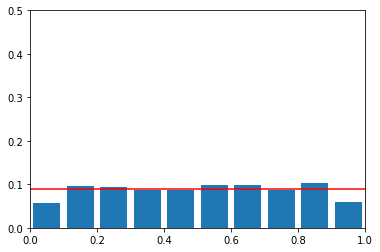

In [174]:

import sklearn as sk
enc = sk.preprocessing.OneHotEncoder()
pred_leaves_train = models["model_l_high_reg"].predict(X_train, pred_leaf=True)
pred_reg_train = models["model_l_high_reg"].predict(X_train).reshape(-1, 1)
pred_leaves_train = enc.fit_transform(pred_leaves_train)
print(pred_leaves_train.shape,X_train.shape, type(pred_leaves_train),
      type(X_train))
import scipy.sparse
features_train = scipy.sparse.hstack([X_train,pred_leaves_train])
print(features_train.shape, type(features_train))
features_train = scipy.sparse.hstack([features_train, pred_reg_train])
print(features_train.shape, type(features_train))


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

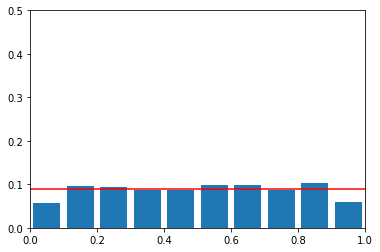

In [180]:
t1 = time.time()
stacker.fit(features_train,ml_model.label(Y_train[ycol],threshold=0.15))
# stacker.fit(features_train,Y_train[ycol])
t2 = time.time()
print(t2-t1)

C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

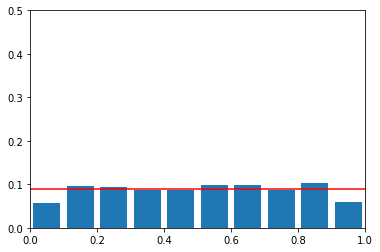

In [176]:
pred_leaves_test = models["model_l_high_reg"].predict(X_test, pred_leaf=True)
pred_reg_test = models["model_l_high_reg"].predict(X_test).reshape(-1, 1)
pred_leaves_test = enc.transform(pred_leaves_test)
print(pred_leaves_test.shape,X_test.shape, type(pred_leaves_test),
      type(X_test))
features_test = scipy.sparse.hstack([X_test, pred_leaves_test])
print(features_test.shape, type(features_test))
features_test = scipy.sparse.hstack([features_test, pred_reg_test])
print(features_test.shape, type(features_test))


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\lightgbm\basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


(16568,)


1292 (0.0564942141165419, 0.025359140081381515, 0.07957201925528411, 0.49437299035369775, -0.014883061658398145)
3497 (0.09504616791963497, 0.0726246105919004, 0.09024243654398367, 0.741324921135647, -0.09234608985024961)
3106 (0.09408139306308058, 0.07244620752160258, 0.08945663814447036, 0.7047560222359481, -0.09142053445850917)
2325 (0.08616052449963223, 0.06269592476489039, 0.08869867514290783, 0.6974169741697416, -0.058252427184466105)
2245 (0.08677626347111263, 0.06336206896551722, 0.08857897064228236, 0.7660103626587744, -0.04995196926032652)
2344 (0.09731225216002441, 0.07690981432360733, 0.0895432363424026, 0.597989949748744, -0.0632380952380952)
1277 (0.09841958194967271, 0.07598944591029033, 0.0909535346164598, 0.5143859649122804, -0.06426056338028152)
450 (0.0868233603157824, 0.06349306651094266, 0.08943101591540087, 0.476747587013747, -0.10578478964401283)
20 (0.10391456215211621, 0.07400945030202, 0.09942987060625445, 0.31241084165477906, -0.0139113555483662)
12 (0.060183

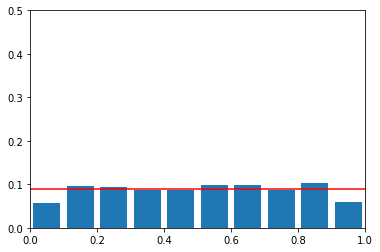

In [182]:
y_stacker_test = stacker.predict_proba(features_test)[:,1]
# y_stacker_test = stacker.predict(features_test)

print(y_stacker_test.shape)
y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0 < y_stacker_test) & (y_stacker_test <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*0.1+0.05,[mean for mean,_, _,_,_ in y1],width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

1326 (0.05300187716074075, 0.03308823529411753, 0.06798710405848696, 0.49437299035369775, -0.0802784222737819)
3791 (0.08169611091496407, 0.06577674598568395, 0.0770471715304999, 0.7047560222359481, -0.09234608985024961)
4600 (0.0954054952655391, 0.07150242682320973, 0.09287538335366147, 0.7660103626587744, -0.10578478964401283)
3924 (0.1027389176762603, 0.08209720684106714, 0.09448112354882743, 0.687140115163148, -0.0708556149732621)
2013 (0.09244614905303818, 0.06636155606407335, 0.09527008629166818, 0.6616257088846884, -0.06614785992217898)
707 (0.09027971770424402, 0.06840390879478808, 0.09001769234164252, 0.6727145847871598, -0.06426056338028152)
175 (0.08644868039283672, 0.05530371713508608, 0.10724783138312466, 0.597989949748744, -0.10079184002147368)
9 (0.1409031613014754, 0.06234448437931972, 0.15249107697152783, 0.3953757225433525, -0.0139113555483662)
0 (nan, nan, nan, nan, nan)
0 (nan, nan, nan, nan, nan)


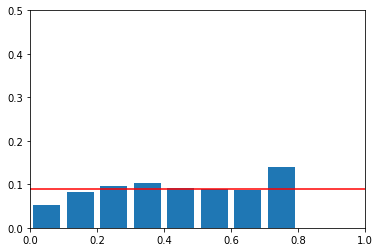

In [159]:
y1 = []
cnt1 = []
for i in range(10):
    p0 = i*0.1
    p1 = (i+1)*0.1
    cond=(p0 < Y_test_pred_reg[ycol]) & (Y_test_pred_reg[ycol] <=p1)
    cnt1.append(sum(cond))
    y1.append((Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min()))
for c,p in zip(cnt1,y1):
    print(c,p)

plt.bar(np.arange(len(y1))*0.1+0.05,[mean for mean,_, _,_,_ in y1],width=0.08)
plt.plot(x0,y0,color='r')
# plt.plot(x,y1,color='r')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

In [77]:
cond = Y_test_pred_reg[ycol]>0.8
print(Y_test[ycol][cond].mean())
print(sum(cond),Y_test[ycol][cond].mean(), Y_test[ycol][cond].median(),Y_test[ycol][cond].std(),Y_test[ycol][cond].max(),Y_test[ycol][cond].min())

df_combined = df_all.loc[test_date_idx][["code","open0","open","f1mv_open"]]
df_combined["rise"] = Y_test[ycol].copy()
df_combined["pred"] = Y_test_pred_reg[ycol].copy()
for code, df in df_combined[cond].groupby("code"):
    print("\n",df)

0.27052899250361223
6 0.27052899250361223 0.2563892418087791 0.06462782352327352 0.3700854700854703 0.18000000000000016



                  code  open0     open  f1mv_open      rise      pred
2018-02-06  002446.SZ    7.2  35.6184   34.67847  0.312411  0.812218

                  code  open0   open  f1mv_open  rise      pred
2018-02-01  002913.SZ  40.86  40.86       38.0  0.18  0.808325

                  code  open0      open  f1mv_open      rise      pred
2018-02-01  600536.SH  13.43  70.88354   62.80820  0.247899  0.803867
2018-02-02  600536.SH  11.90  62.80820   62.01650  0.263830  0.820246
2018-02-05  600536.SH  11.75  62.01650   62.75542  0.248949  0.844401
2018-02-06  600536.SH  11.89  62.75542   61.75260  0.370085  0.869043
